### **Table of Contents**
* [Reading in the data](#reading-in-the-data)
* [cleaning](#cleaning)
  * [Feature engineering](#feature-engineering)
* [Function list](#function-list)
  * [filter](#filter)
* [Average Hours Worked by Department](#average-hours-worked-by-department)
* [Employee Count by Department working more than 52 hrs](#employee-count-by-department-working-more-than-52-hrs)
* [Overtime Cost by Department](#overtime-cost-by-department)
  * [Total overtime spend](#total-overtime-spend)


In [335]:
import pandas as pd
from pandas.testing import assert_frame_equal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as mticker
from pypalettes import load_cmap
from highlight_text import ax_text
from drawarrow import ax_arrow
from cycler import cycler

# formatting notebook to show rounded values.
pd.options.display.float_format = '{:,.2f}'.format

# Reading in the data 

- Reading in the data 
- finding the data types for each column. 
- optimized each column to not have objects as they are more memory hungry.  

In [336]:
def read_salary_csv(filepath: str) -> pd.DataFrame:
    """
    Read a salary CSV file with optimized dtypes for memory efficiency.
    
    Parameters:
        filepath (str): Path to the CSV file.
        
    Returns:
        pd.DataFrame: Loaded DataFrame with optimized dtypes.
    """
    optimized_dtypes = {
        "CalYear": "int16",
        "Employee_Name": "string",
        "Department": "category",
        "jobTitle": "category",
        "Annual_Rate": "float32",
        "Regular_Rate": "float32",
        "Overtime_Rate": "float32",
        "Incentive_Allowance": "float32",
        "Other": "float32",
        "YTD_Total": "float32",
        "ObjectId": "int32"
    }
    
    sal = pd.read_csv(filepath, dtype=optimized_dtypes)
    return sal

# Example usage:
sal = read_salary_csv("data/salary2.csv")
sal.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total,ObjectId
0,2021,<NA>,Belle of Louisville,Hospitality Worker,"3,120.00",687.00,0.00,0.00,NaN,687.00,1
1,2021,<NA>,Parks & Recreation,Park Aide,"31,200.00",600.00,0.00,0.00,NaN,600.00,2
2,2021,"Martin, David",Library,Library Page L/U,"28,433.60","28,412.56",0.00,"1,450.00",NaN,"30,862.81",3
3,2021,"Bratcher, Elaine",Louisville Metro Police,Clerk Typist II-Police,"35,256.00","35,256.01",0.00,"1,563.12",NaN,"36,819.13",4
4,2021,"Jackson, Nila",Louisville Metro Police,Traffic Guard II,"21,418.80","16,529.14",952.39,"1,000.00",NaN,"18,481.53",5


# cleaning 

In [337]:
def clean_salaries(sal: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing values for specific columns and drop unnecessary columns.

    - Fills missing 'Employee_Name' with 'Unknown'
    - Fills missing 'Other' with 0
    - Drops the 'Other' column

    Returns the cleaned DataFrame.
    """
    # Fill missing values
    sal = sal.fillna({
        "Employee_Name": "Unknown",
        "Other": 0
    })

    # Drop 'Other' column
    if "Other" in sal.columns:
        sal = sal.drop("Other", axis=1)

    return sal

# Example usage
sal = clean_salaries(sal)
sal.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,YTD_Total,ObjectId
0,2021,Unknown,Belle of Louisville,Hospitality Worker,"3,120.00",687.00,0.00,0.00,687.00,1
1,2021,Unknown,Parks & Recreation,Park Aide,"31,200.00",600.00,0.00,0.00,600.00,2
2,2021,"Martin, David",Library,Library Page L/U,"28,433.60","28,412.56",0.00,"1,450.00","30,862.81",3
3,2021,"Bratcher, Elaine",Louisville Metro Police,Clerk Typist II-Police,"35,256.00","35,256.01",0.00,"1,563.12","36,819.13",4
4,2021,"Jackson, Nila",Louisville Metro Police,Traffic Guard II,"21,418.80","16,529.14",952.39,"1,000.00","18,481.53",5


## Feature engineering
Calculating pay and hours for people. 

- Each function has a test to verify that it works as intended
- It calls a tiny data set and does the calculations

In [338]:
def hr_rate(sal):
  # Calculate Hourly Rate and apply minimum wage rule
  sal["Hr_Rate"] = sal["Annual_Rate"] / 2080 

  # If hourly rate is less than $7.25, replace it with $7.25 (minimum wage floor)
  sal["Hr_Rate"] = sal["Hr_Rate"].mask(sal["Hr_Rate"] < 7.25, 7.25)

  # Calculate Overtime Rate
  sal["Ot_Rate"] = sal["Hr_Rate"] * 1.5
  return sal

def hr_rate_test():
    # Test data
    df = pd.DataFrame({
        'Employee_Name': ['Steve', 'Bill'], 
        'Annual_Rate': [40000, 10000]
    })

    expected = pd.DataFrame({
        'Employee_Name': ['Steve', 'Bill'], 
        'Annual_Rate': [40000, 10000],
        'Hr_Rate': [19.23, 7.25],
        'Ot_Rate': [28.85, 10.88]
    })

    # Run function
    result = hr_rate(df.copy())

    # Round to 2 decimals for comparison
    result[["Hr_Rate", "Ot_Rate"]] = result[["Hr_Rate", "Ot_Rate"]].round(2)

    # Test
    assert_frame_equal(result, expected)
    print("✅ Test passed!")

hr_rate_test()

✅ Test passed!


In [339]:
def part_time_filter(sal):
  # Filter out part-time employees
  sal['Reg_Hours'] = sal["Annual_Rate"] / sal["Hr_Rate"]

  # Keep only full-time employees (≥ 2080 hours)
  sal = sal[sal['Reg_Hours'] >= 2080]
  return sal 

def part_time_test():
    # Test data
    df = pd.DataFrame({'Employee_Name': ['Steve', 'Bill'], 
                   'Annual_Rate': [40000, 10000],
                   'Hr_Rate': [19.23, 7.25],
                   'Ot_Rate': [28.84, 10.88]})

    expected = pd.DataFrame({'Employee_Name': ['Steve'], 
                   'Annual_Rate': [40000],
                   'Hr_Rate': [19.23],
                   'Ot_Rate': [28.84],
                   'Reg_Hours': [2080]})

    # Run function
    result = part_time_filter(df.copy())

    # Round to 2 decimals for comparison
    result[["Hr_Rate", "Ot_Rate", 'Reg_Hours']] = result[["Hr_Rate", "Ot_Rate", 'Reg_Hours']].round(2)

    # Test
    assert_frame_equal(result, expected)
    print("✅ Test passed!")

hr_rate_test()

✅ Test passed!


In [340]:
def hour_calc(sal):
  # 4️ Calculate regular hours worked (based on Regular_Rate)
  sal['Rg_Hours'] = sal["Regular_Rate"] / sal["Hr_Rate"]

  # 5️ Calculate overtime hours worked
  sal['Ot_Hours'] = sal["Overtime_Rate"] / sal["Ot_Rate"]

  # 6️ Total hours worked
  sal['Total_Hours'] = sal['Reg_Hours'] + sal['Ot_Hours']

  # 7️ Estimate number of weeks worked
  sal["Weeks_Worked"] = sal["Regular_Rate"] / (sal["Hr_Rate"] * 40) 
  return sal


def hour_calc_test():
    # Test data
    df = pd.DataFrame({
       'Employee_Name': ['Steve'], 
        'Annual_Rate': [40000],
        'Regular_Rate': [40000],
        'Overtime_Rate': [288.40],
        'Hr_Rate': [19.23],
        'Ot_Rate': [28.84],
        'Reg_Hours': [2080]})

    expected = pd.DataFrame({
        'Employee_Name': ['Steve'],
        'Annual_Rate': [40000],
        'Regular_Rate': [40000],
        'Overtime_Rate': [288.40],
        'Hr_Rate': [19.23],
        'Ot_Rate': [28.84],
        'Reg_Hours': [2080],
        'Rg_Hours': [2080.08],
        'Ot_Hours': [10.0],
        'Total_Hours': [2090.00],
        'Weeks_Worked': [52.00]})

    # Run function
    result = hour_calc(df.copy())

    # Round all numeric columns to 2 decimals for comparison
    numeric_cols = result.select_dtypes(include='number').columns
    result[numeric_cols] = result[numeric_cols].round(2)

    # Test
    assert_frame_equal(result, expected)
    print("✅ Test passed!")


# Run the test
hour_calc_test()

✅ Test passed!


In [341]:
def week_calc(sal):
  # 8️ Regular hours per week
  sal["Reg_Hrs_per_Week"] = sal["Regular_Rate"] / (sal["Hr_Rate"] * sal["Weeks_Worked"])

  # 9️ Overtime hours per week
  sal["Ot_Hrs_per_Week"] = sal["Overtime_Rate"] / (sal["Ot_Rate"] * sal["Weeks_Worked"])

  # 10 Average hours per week
  sal["Avg_Hrs_per_Week"] = sal["Reg_Hrs_per_Week"] + sal["Ot_Hrs_per_Week"]
  return sal

def week_calc_test():
    # Test data
    df = pd.DataFrame({
       'Employee_Name': ['Steve'], 
        'Annual_Rate': [40000],
        'Regular_Rate': [40000],
        'Overtime_Rate': [288.40],
        'Hr_Rate': [19.23],
        'Ot_Rate': [28.84],
        'Reg_Hours': [2080]})

    expected = pd.DataFrame({
        'Employee_Name': ['Steve'],
        'Annual_Rate': [40000],
        'Regular_Rate': [40000],
        'Overtime_Rate': [288.40],
        'Hr_Rate': [19.23],
        'Ot_Rate': [28.84],
        'Reg_Hours': [2080],
        'Rg_Hours': [2080.08],
        'Ot_Hours': [10.0],
        'Total_Hours': [2090.00],
        'Weeks_Worked': [52.00],
        'Reg_Hrs_per_Week': [40.00],
        'Ot_Hrs_per_Week': [0.19],
        'Avg_Hrs_per_Week': [40.19],})

    # Run function
    result = week_calc(df.copy())

    # Round all numeric columns to 2 decimals for comparison
    numeric_cols = result.select_dtypes(include='number').columns
    result[numeric_cols] = result[numeric_cols].round(2)

    # Test
    assert_frame_equal(result, expected)
    print("✅ Test passed!")


# Run the test
hour_calc_test()

✅ Test passed!


# Function list 

``` python 
hr_rate(sal)
part_time_filter(sal)
hour_calc(sal)
week_calc(sal)
```

In [342]:
sal = hr_rate(sal)
sal = part_time_filter(sal)
sal = hour_calc(sal)
sal = week_calc(sal)

In [343]:
sal.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,YTD_Total,ObjectId,Hr_Rate,Ot_Rate,Reg_Hours,Rg_Hours,Ot_Hours,Total_Hours,Weeks_Worked,Reg_Hrs_per_Week,Ot_Hrs_per_Week,Avg_Hrs_per_Week
1,2021,Unknown,Parks & Recreation,Park Aide,"31,200.00",600.00,0.00,0.00,600.00,2,15.00,22.50,"2,080.00",40.00,0.00,"2,080.00",1.00,40.00,0.00,40.00
2,2021,"Martin, David",Library,Library Page L/U,"28,433.60","28,412.56",0.00,"1,450.00","30,862.81",3,13.67,20.51,"2,080.00","2,078.46",0.00,"2,080.00",51.96,40.00,0.00,40.00
3,2021,"Bratcher, Elaine",Louisville Metro Police,Clerk Typist II-Police,"35,256.00","35,256.01",0.00,"1,563.12","36,819.13",4,16.95,25.43,"2,080.00","2,080.00",0.00,"2,080.00",52.00,40.00,0.00,40.00
4,2021,"Jackson, Nila",Louisville Metro Police,Traffic Guard II,"21,418.80","16,529.14",952.39,"1,000.00","18,481.53",5,10.30,15.45,"2,080.00","1,605.16",61.66,"2,141.66",40.13,40.00,1.54,41.54
5,2021,"Ammon, Darrell",Louisville Metro Police,Criminal Justice Specialist,"50,107.20","49,362.47",0.00,0.00,"49,362.47",6,24.09,36.14,"2,080.00","2,049.09",0.00,"2,080.00",51.23,40.00,0.00,40.00


In [344]:
dept_counts = sal["Department"].value_counts()
dept_counts.iloc[40:60]

Department
Mayor Office                               137
Parking Authority of River City - PARC     133
Youth Transitional Services                123
Air Pollution Control                      109
KentuckianaWorks                           107
Office of Violence Prevention              107
Office for Safe & Healthy Neighborhoods     96
Human Relations Commission                  85
Youth Detention Services                    85
Jefferson County Coroner                    78
Waterfront Development Corporation          76
Parking Authority of River Cty              71
Safe & Healthy Neighborhoods                49
Kentuckiana Works Foundation                47
Mayor's Office                              40
Alcoholic Beverage Control                  40
Records Compliance                          39
Waterfront Development Corp                 35
Coroner                                     35
Office of Internal Audit                    29
Name: count, dtype: int64

In [345]:
# sal["Department"][sal["Department"].str.contains("Office of Social Services", case=False, na=False)].tolist()


## filter 

filtering to 2025 Office of Social Services as they are the ones who deal with the homeless. 

In [346]:
social = sal.query(
    "CalYear == 2025 and Department == 'Office of Social Services'")
social = social.sort_values(by='Avg_Hrs_per_Week', ascending=False)
social = social.dropna(subset=["Avg_Hrs_per_Week"])

social

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,YTD_Total,ObjectId,Hr_Rate,Ot_Rate,Reg_Hours,Rg_Hours,Ot_Hours,Total_Hours,Weeks_Worked,Reg_Hrs_per_Week,Ot_Hrs_per_Week,Avg_Hrs_per_Week
7227,2025,"Young, Latonya D",Office of Social Services,Grants Contract Coordinator,"64,043.20","50,090.89","3,264.70",0.00,"53,355.59",7228,30.79,46.18,"2,080.00","1,626.86",70.69,"2,150.69",40.67,40.00,1.74,41.74
10402,2025,"Jude, Richard Bradley",Office of Social Services,Community Outreach Supervisor,"60,444.80","32,301.97","1,339.62",0.00,"41,056.84",10403,29.06,43.59,"2,080.00","1,111.56",30.73,"2,110.73",27.79,40.00,1.11,41.11
12385,2025,"Cromer, Barry Allen",Office of Social Services,Homeless Resource Outreach Specialist,"44,200.00","34,951.43","1,411.52","1,000.00","37,362.95",12386,21.25,31.88,"2,080.00","1,644.77",44.28,"2,124.28",41.12,40.00,1.08,41.08
6603,2025,"Hoover, Mark",Office of Social Services,Homeless Encampment Response Supervisor,"78,582.40","61,798.04","1,744.52",0.00,"63,542.56",6604,37.78,56.67,"2,080.00","1,635.73",30.78,"2,110.78",40.89,40.00,0.75,40.75
9996,2025,"Marlow, Yulaine D",Office of Social Services,Grants Contract Coordinator,"68,681.60","53,658.72","1,442.06",0.00,"55,100.78",9997,33.02,49.53,"2,080.00","1,625.04",29.11,"2,109.11",40.63,40.00,0.72,40.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7583,2025,"Ealom, Patrice Lynell Gilbert",Office of Social Services,Social Service Program Supervisor I,"77,833.60","60,918.14",0.00,0.00,"60,918.14",7584,37.42,56.13,"2,080.00","1,627.96",0.00,"2,080.00",40.70,40.00,0.00,40.00
7514,2025,"Hartman, Carol Ruth",Office of Social Services,Sr. Social Worker U315,"60,465.60","48,837.67",0.00,0.00,"48,837.67",7515,29.07,43.61,"2,080.00","1,680.00",0.00,"2,080.00",42.00,40.00,0.00,40.00
7372,2025,"Barnswell, Johnny L",Office of Social Services,Sr. Social Worker U315,"61,588.80","49,744.84",0.00,0.00,"49,744.84",7373,29.61,44.42,"2,080.00","1,680.00",0.00,"2,080.00",42.00,40.00,0.00,40.00
7263,2025,"Goodloe, Vickie Renna",Office of Social Services,Management Assistant - U315,"35,547.20","28,711.21",0.00,0.00,"28,711.21",7264,17.09,25.64,"2,080.00","1,680.00",0.00,"2,080.00",42.00,40.00,0.00,40.00


Office of Social Services has 141 employees 
They are all full time and broadly work no over time. 

In [347]:
social["Avg_Hrs_per_Week"].describe()

count   141.00
mean     40.06
std       0.22
min      40.00
25%      40.00
50%      40.00
75%      40.01
max      41.74
Name: Avg_Hrs_per_Week, dtype: float64

In [348]:
dept_hours = (
    sal.groupby("Department")["Avg_Hrs_per_Week"]
       .mean()
       .sort_values(ascending=False)
)
dept_hours

/var/folders/5n/c3w4ghd568g97rbg1g82w39m0000gn/T/ipykernel_25480/18785809.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sal.groupby("Department")["Avg_Hrs_per_Week"]


Department
Louisville Fire                                56.09
Emergency Management Services                  52.22
Louisville Metro EMS                           50.47
Department of Corrections                      47.19
Emergency Mgt Agency/MetroSafe                 47.05
                                                ... 
Office of Performance Improvement (inactive)   40.00
Internal Auditor                               40.00
Office of Strategic Initiatives                40.00
Office of Philanthropy                         40.00
Insurance & Risk Management                      NaN
Name: Avg_Hrs_per_Week, Length: 78, dtype: float32

# Average Hours Worked by Department

| Department                                 | Avg Hours |
|-----------------|--:|
| Louisville Fire                             | 56.09 |
| Emergency Management Services               | 52.22 |
| Louisville Metro EMS                        | 50.47 |
| Department of Corrections                   | 47.19 |
| Emergency Mgt Agency/MetroSafe              | 47.05 |
| ES & MetroSafe                              | 46.54 |
| Solid Waste Management                      | 45.62 |
| Metro Corrections                           | 45.07 |
| Louisville Metro Police Department          | 44.85 |
| Louisville Metro Police                     | 43.88 |
| Youth Transitional Services                 | 43.26 |
| Public Works & Assets                       | 43.14 |
| Alcoholic Beverage Control                  | 42.41 |
| Records Compliance                          | 41.94 |
| Alcohol Beverage Control                    | 41.65 |
| Metro Animal Services                       | 41.23 |
| Youth Detention Services                    | 41.19 |
| PWA - Solid Waste Management Services       | 41.09 |
| Public Works                                | 41.07 |
| Codes & Regulations                         | 41.00 |


In [349]:
dept_hours.head(20)

Department
Louisville Fire                         56.09
Emergency Management Services           52.22
Louisville Metro EMS                    50.47
Department of Corrections               47.19
Emergency Mgt Agency/MetroSafe          47.05
ES & MetroSafe                          46.54
Solid Waste Management                  45.62
Metro Corrections                       45.07
Louisville Metro Police Department      44.85
Louisville Metro Police                 43.88
Youth Transitional Services             43.26
Public Works & Assets                   43.14
Alcoholic Beverage Control              42.41
Records Compliance                      41.94
Alcohol Beverage Control                41.65
Metro Animal Services                   41.23
Youth Detention Services                41.19
PWA - Solid Waste Management Services   41.09
Public Works                            41.07
Codes & Regulations                     41.00
Name: Avg_Hrs_per_Week, dtype: float32

Looking at employees with over 52 average hours per week in 2025.

In [350]:
dep_over = sal[(sal["Avg_Hrs_per_Week"] > 52) & (sal["CalYear"] == 2025)]
dep_over = dep_over.sort_values("Avg_Hrs_per_Week", ascending=False)
dep_over = dep_over[~dep_over["Employee_Name"].isin(["Leonard, Dillon Michael"])]
dep_over["Department"].value_counts()
dep_over.head(10)

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,YTD_Total,ObjectId,Hr_Rate,Ot_Rate,Reg_Hours,Rg_Hours,Ot_Hours,Total_Hours,Weeks_Worked,Reg_Hrs_per_Week,Ot_Hrs_per_Week,Avg_Hrs_per_Week
7293,2025,"Fenwick, Paul E",Louisville Metro Police Department,Police Officer,"95,555.20","75,315.67","134,672.06","10,093.88","220,081.61",7294,45.94,68.91,"2,080.00","1,639.44","1,954.32","4,034.32",40.99,40.00,47.68,87.68
7810,2025,"Standard, Royce Leshawn",Department of Corrections,Corrections Officer,"69,596.80","55,491.41","95,985.71",0.00,"151,477.12",7811,33.46,50.19,"2,080.00","1,658.44","1,912.45","3,992.45",41.46,40.00,46.13,86.13
8618,2025,"Stimphil, Richardson",Department of Corrections,Corrections Officer,"66,331.20","50,618.52","86,647.31",0.00,"137,265.83",8619,31.89,47.84,"2,080.00","1,587.28","1,811.38","3,891.38",39.68,40.00,45.65,85.65
13223,2025,"Mann, Mikayla Faith",Emergency Management Services,EMS EMT-Paramedic I,"62,046.40","3,740.70","6,106.35",0.00,"9,847.05",13224,29.83,44.74,"2,080.00",125.40,136.47,"2,216.47",3.14,40.00,43.53,83.53
7621,2025,"Bethel, Ronald G",Department of Corrections,Corrections Officer,"69,596.80","55,065.98","89,034.62",0.00,"144,100.59",7622,33.46,50.19,"2,080.00","1,645.73","1,773.95","3,853.95",41.14,40.00,43.12,83.12
8464,2025,"Roberts, Bryan Keith",Department of Corrections,Corrections Officer,"62,712.00","48,632.44","70,165.76",0.00,"118,838.20",8465,30.15,45.22,"2,080.00","1,613.02","1,551.48","3,631.48",40.33,40.00,38.47,78.47
13448,2025,"Travers, Thomas Joseph",Emergency Management Services,EMS EMT-Paramedic I,"63,564.80","2,933.76","4,228.02",0.00,"7,161.78",13449,30.56,45.84,"2,080.00",96.00,92.23,"2,172.23",2.40,40.00,38.43,78.43
8760,2025,"Jones, Dontorya J",Emergency Management Services,EMT,"66,310.40","58,164.35","82,300.08",350.00,"141,642.44",8761,31.88,47.82,"2,080.00","1,824.48","1,721.04","3,801.04",45.61,40.00,37.73,77.73
7571,2025,"Wingler, Chad E",Department of Corrections,Corrections Sergeant,"62,088.00","50,685.62","69,635.63",0.00,"120,321.25",7572,29.85,44.78,"2,080.00","1,698.01","1,555.23","3,635.23",42.45,40.00,36.64,76.64
6801,2025,"Murphy, Paul P.",Louisville Fire,Fire Apparatus Operator 56hr,"79,465.98","38,968.05","53,258.17","22,946.02","115,718.03",6802,38.20,57.31,"2,080.00","1,019.98",929.35,"3,009.35",25.50,40.00,36.45,76.45


# Employee Count by Department working more than 52 hrs

| Department                           | Count |
|--|----------------------:|
| Louisville Fire                      | 380 |
| Louisville Metro Police Department   | 169 |
| Department of Corrections            | 96 |
| Emergency Management Services        | 92 |
| ES & MetroSafe                       | 19 |
| Public Works & Assets                | 16 |
| Youth Transitional Services          | 4 |
| Belle of Louisville                  | 1 |
| Codes & Regulations                  | 1 |
| Parks & Recreation                   | 1 |


In [351]:
dep_over["Department"].value_counts().head(10)

Department
Louisville Fire                       380
Louisville Metro Police Department    169
Department of Corrections              96
Emergency Management Services          92
ES & MetroSafe                         19
Public Works & Assets                  16
Youth Transitional Services             4
Belle of Louisville                     1
Codes & Regulations                     1
Parks & Recreation                      1
Name: count, dtype: int64

In [352]:
dep_over = dep_over.sort_values("YTD_Total", ascending=False)
dep_over.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,YTD_Total,ObjectId,Hr_Rate,Ot_Rate,Reg_Hours,Rg_Hours,Ot_Hours,Total_Hours,Weeks_Worked,Reg_Hrs_per_Week,Ot_Hrs_per_Week,Avg_Hrs_per_Week
7293,2025,"Fenwick, Paul E",Louisville Metro Police Department,Police Officer,"95,555.20","75,315.67","134,672.06","10,093.88","220,081.61",7294,45.94,68.91,"2,080.00","1,639.44","1,954.32","4,034.32",40.99,40.00,47.68,87.68
7283,2025,"Cadwell, Corey R",Louisville Metro Police Department,Police Sergeant,"111,550.40","89,179.76","100,464.80","7,711.35","197,355.91",7284,53.63,80.44,"2,080.00","1,662.87","1,248.86","3,328.86",41.57,40.00,30.04,70.04
7901,2025,"Lokits, Christopher T",Emergency Management Services,EMS EMT-Paramedic II,"107,889.60","82,468.46","99,189.31",350.00,"182,007.77",7902,51.87,77.81,"2,080.00","1,589.91","1,274.84","3,354.84",39.75,40.00,32.07,72.07
7400,2025,"Godfrey, Jensen R",Louisville Metro Police Department,Police Lieutenant,"133,702.41","107,034.93","61,283.82","5,614.19","173,932.94",7401,64.28,96.42,"2,080.00","1,665.14",635.59,"2,715.59",41.63,40.00,15.27,55.27
6584,2025,"Clarkson, Joseph Brian",Louisville Metro Police Department,Police Officer,"95,555.20","77,131.71","85,587.38","7,621.58","170,340.67",6585,45.94,68.91,"2,080.00","1,678.97","1,242.02","3,322.02",41.97,40.00,29.59,69.59


In [353]:
dep_over["YTD_Total"].describe()

count       779.00
mean     86,913.44
std      29,303.38
min         573.22
25%      67,842.02
50%      82,657.69
75%     103,320.42
max     220,081.61
Name: YTD_Total, dtype: float64

In [354]:
# List of departments
departments = [
    "Louisville Fire",
    "Louisville Metro Police Department",
    "Department of Corrections",
    "Emergency Management Services",
    "ES & MetroSafe",
    "Public Works & Assets",
    "Youth Transitional Services",
    "Belle of Louisville",
    "Codes & Regulations",
    "Parks & Recreation"
]

# Filter and group by department, summing Overtime_Rate
department_overtime = (
    sal[sal["Department"].isin(departments)]
       .groupby("Department", as_index=False)["Overtime_Rate"]
       .sum()
       .sort_values("Overtime_Rate", ascending=False)
)

department_overtime.head(10)


/var/folders/5n/c3w4ghd568g97rbg1g82w39m0000gn/T/ipykernel_25480/1641596459.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Department", as_index=False)["Overtime_Rate"]


,Department,Overtime_Rate
35,Louisville Metro Police Department,"76,731,984.00"
31,Louisville Fire,"73,798,384.00"
11,Department of Corrections,"26,451,200.00"
15,Emergency Management Services,"15,373,277.00"
68,Public Works & Assets,"10,929,036.00"
13,ES & MetroSafe,"10,077,773.00"
6,Codes & Regulations,"1,513,646.50"
65,Parks & Recreation,"1,352,234.38"
77,Youth Transitional Services,"669,389.56"
4,Belle of Louisville,"184,506.55"


# Overtime Cost by Department

| Department                           | Overtime Rate ($)      |
|--------------------------------------|------------------------:|
| Louisville Metro Police Department   | 76,731,984 |
| Louisville Fire                      | 73,798,384 |
| Department of Corrections            | 26,451,200 |
| Emergency Management Services        | 15,373,277 |
| Public Works & Assets                | 10,929,036 |
| ES & MetroSafe                       | 10,077,773 |
| Codes & Regulations                  | 1,513,646 |
| Parks & Recreation                   | 1,352,234 |
| Youth Transitional Services          | 669,389 |
| Belle of Louisville                  | 184,506 |
| | |
| TOTAL                                | 217,081,429 |


## Total overtime spend 

In [355]:
department_overtime['Overtime_Rate'] = department_overtime['Overtime_Rate'].astype(int)
total_overtime = department_overtime['Overtime_Rate'].sum()
total_overtime


np.int64(217081429)

In [356]:
# Define your custom colors
colors = ['#FEBE10', '#1D1E9E', '#AD0000', '#000000', '#FFFFFF']

plt.rcParams.update({
    # Colors
    'axes.prop_cycle': cycler('color', colors),

    # Background
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey',
    'savefig.facecolor': 'lightgrey',

    # Grid
    'axes.grid': True,
    'grid.color': '#000000',
    'grid.alpha': 0.1,
    'grid.linestyle': '--',

    # Lines & markers
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'lines.markeredgewidth': 0.5,

    # Axes & ticks
    'axes.edgecolor': '#000000',
    'axes.labelcolor': '#000000',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,

    # Legend
    'legend.frameon': False,
    'legend.fontsize': 10,
    'legend.loc': 'best',

    # Font
    'font.family': 'DejaVu Sans',
    'text.color': '#000000',

    # Savefig
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

In [357]:
# Create the formatter once
formatter = mticker.StrMethodFormatter("{x:,.0f}")

def apply_formatter(ax=None):
    """Automatically format numeric axes with commas, leave text/categorical axes alone."""
    if ax is None:
        ax = plt.gca()
    
    # Format x-axis only if tick labels are numbers
    x_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
    if all(_is_number(lbl) for lbl in x_labels):
        ax.xaxis.set_major_formatter(formatter)
    
    # Format y-axis only if tick labels are numbers
    y_labels = [lbl.get_text() for lbl in ax.get_yticklabels()]
    if all(_is_number(lbl) for lbl in y_labels):
        ax.yaxis.set_major_formatter(formatter)

def _is_number(s):
    """Helper to check if string can be converted to float."""
    try:
        float(s.replace(',', ''))  # remove commas if already formatted
        return True
    except ValueError:
        return False

In [358]:
department_overtime.head(1)

,Department,Overtime_Rate
35,Louisville Metro Police Department,76731984


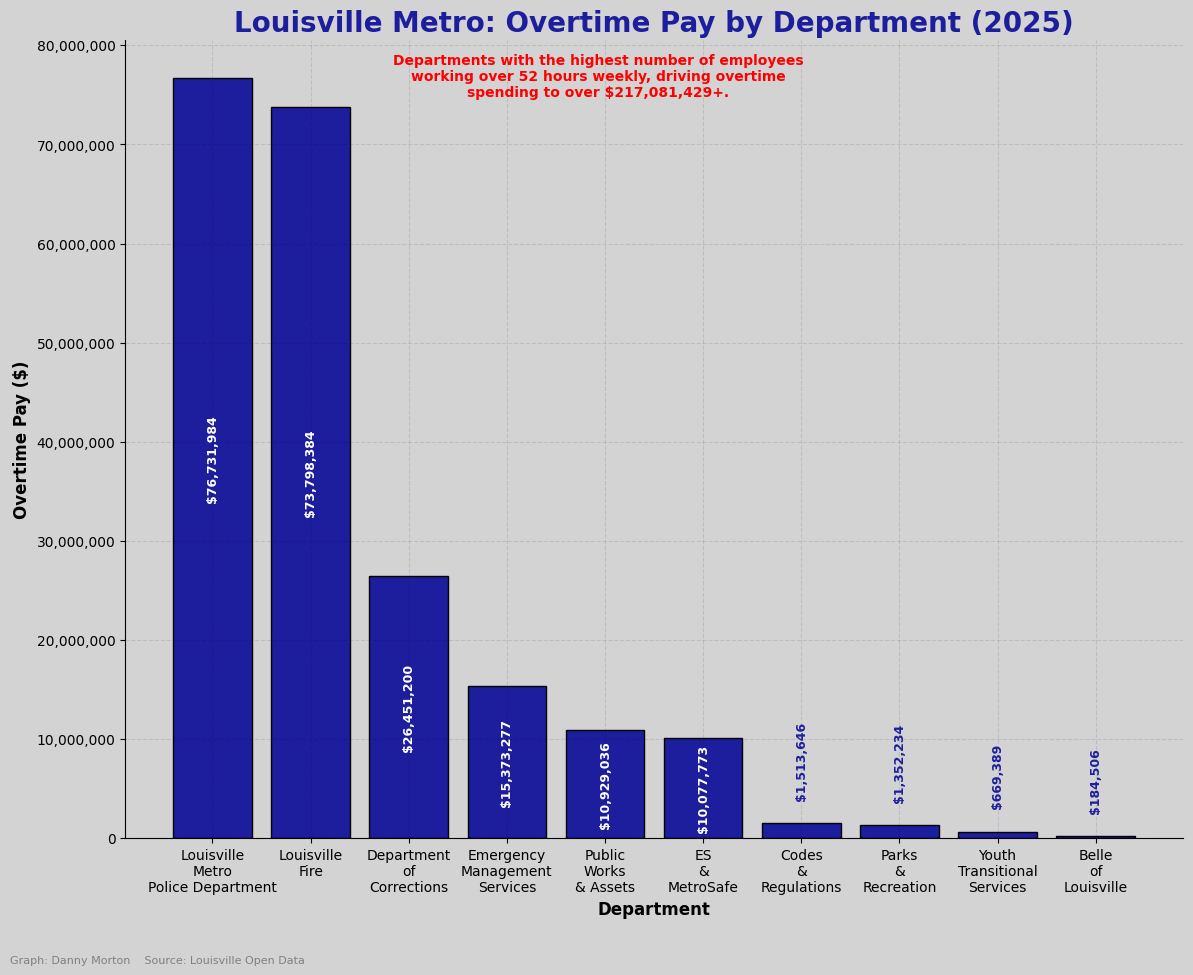

In [366]:
# Sort departments by overtime
department_overtime = department_overtime.sort_values(
    by="Overtime_Rate", ascending=False
).head(10)

plt.figure(figsize=(12, 10))

#  Bar Chart 
plt.bar(
    department_overtime["Department"],
    department_overtime["Overtime_Rate"],
    color="#1D1E9E",
    edgecolor="#000000",
    label="Overtime Pay"
)

#  Add labels inside OR above 
for i, ot in enumerate(department_overtime["Overtime_Rate"]):

    label = f"${ot:,.0f}"

    if ot > department_overtime["Overtime_Rate"].max() * 0.10:
        y = ot * 0.5
        va = "center"
        color = "#FFFFFF"
    else:
        y = ot + (department_overtime["Overtime_Rate"].max() * 0.03)
        va = "bottom"
        color = "#1D1E9E"

    plt.text(
        i, y, label,
        ha="center", va=va,
        rotation=90,
        fontsize=9, fontweight="bold",
        color=color
    )

#  Labels 
plt.xlabel("Department", fontsize=12, weight="bold")
plt.ylabel("Overtime Pay ($)", fontsize=12, weight="bold")

#  Title 
plt.title("Louisville Metro: Overtime Pay by Department (2025)",
          fontsize=20, weight="bold", color="#1D1E9E")

#  Subtitle 
plt.suptitle(
    "Departments with the highest number of employees\n" 
    "working over 52 hours weekly, driving overtime\n" 
    "spending to over $217,081,429+.",
    fontsize=10, color="#FF0000", weight="bold", y=0.88
)

# Caption
plt.figtext(
    0.01, -0.03,
    "Graph: Danny Morton    Source: Louisville Open Data",
    fontsize=8, color="gray"
)

# Apply number formatting
apply_formatter()

wrapped_labels = [
    "\n".join(
        name.split(" ", 2)[:2] +
        ([name.split(" ", 2)[2]] if len(name.split(" ", 2)) > 2 else [])
    )
    for name in department_overtime["Department"]
]

plt.xticks(
    ticks=range(len(wrapped_labels)),
    labels=wrapped_labels,
    rotation=0,
    ha='center'
)
plt.tight_layout()
plt.show()


# Keep this file in your project

keep at the bottom of your project

We will go over it later, its a script that will generate a markdown table of contents based on your headings created here in markdown.

In [367]:
import json
import os


def generate_toc_from_notebook(notebook_path):
    """
    Parses a local .ipynb file and generates Markdown for a Table of Contents.
    """
    if not os.path.isfile(notebook_path):
        print(f"❌ Error: File not found at '{notebook_path}'")
        return

    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    toc_markdown = "### **Table of Contents**\n"
    for cell in notebook.get('cells', []):
        if cell.get('cell_type') == 'markdown':
            for line in cell.get('source', []):
                if line.strip().startswith('#'):
                    level = line.count('#')
                    title = line.strip('#').strip()
                    link = title.lower().replace(' ', '-').strip('-.()')
                    indent = '  ' * (level - 1)
                    toc_markdown += f"{indent}* [{title}](#{link})\n"

    print("\n ✅ Copy the Markdown below and paste"
          "it into a new markdown cell \n")
    print(toc_markdown)


if __name__ == "__main__":
    # Example usage
    notebook_path = 'dannyRefactor.ipynb'  # Replace with your notebook path
    generate_toc_from_notebook(notebook_path)


 ✅ Copy the Markdown below and pasteit into a new markdown cell 

### **Table of Contents**
    * [**Table of Contents**](#**table-of-contents**)
* [Reading in the data](#reading-in-the-data)
* [cleaning](#cleaning)
  * [Feature engineering](#feature-engineering)
* [Function list](#function-list)
  * [filter](#filter)
* [Average Hours Worked by Department](#average-hours-worked-by-department)
* [Employee Count by Department working more than 52 hrs](#employee-count-by-department-working-more-than-52-hrs)
* [Overtime Cost by Department](#overtime-cost-by-department)
  * [Total overtime spend](#total-overtime-spend)
* [Keep this file in your project](#keep-this-file-in-your-project)

